## imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output


### Load Dataset
##### the following dataset contains Iran stock index price since **2014(1393)** to **2019(1397)**

In [2]:
df = pd.read_csv(r"C:\Users\moham\Documents\Projects\stock-price-prediction\data\1393-1397.csv")
df

,name,dateissue,Value
0,????,13971228,178659.1
1,????,13971227,175898.8
2,????,13971226,172522.5
3,????,13971225,171124.9
4,????,13971222,169115.5
...,...,...,...
1208,????,13930111,78741.3
1209,????,13930110,78469.2
1210,????,13930109,78239.7
1211,????,13930106,78619.4


In [3]:
df = df.iloc[::-1] 
df

,name,dateissue,Value
1212,????,13930105,79013.5
1211,????,13930106,78619.4
1210,????,13930109,78239.7
1209,????,13930110,78469.2
1208,????,13930111,78741.3
...,...,...,...
4,????,13971222,169115.5
3,????,13971225,171124.9
2,????,13971226,172522.5
1,????,13971227,175898.8


In [4]:
df = df[["dateissue" , "Value"]] # delete شاخص column

In [5]:
color_pal = sns.color_palette()

In [6]:
df1 = df[df["dateissue"] > 13970211] #barjam date
df2 = df[df["dateissue"] <= 13970211]
df2

,dateissue,Value
1212,13930105,79013.5
1211,13930106,78619.4
1210,13930109,78239.7
1209,13930110,78469.2
1208,13930111,78741.3
...,...,...
223,13970205,94796.1
222,13970208,94284.4
221,13970209,93805.5
220,13970210,93586.9


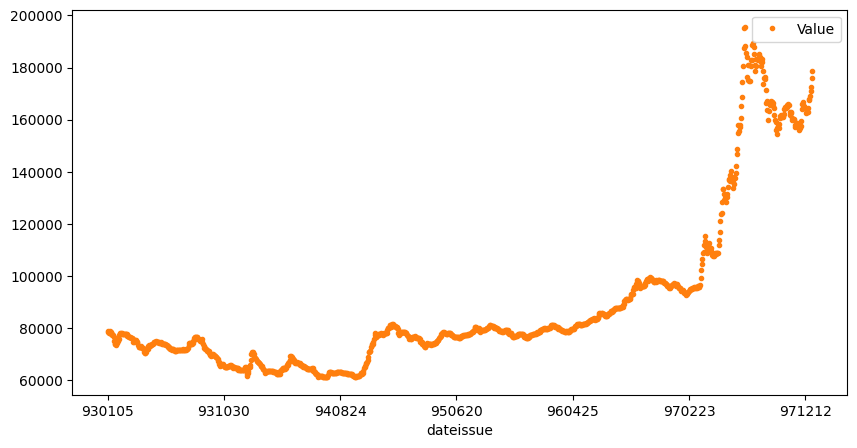

In [7]:
df['dateissue'] = df['dateissue'].apply(lambda x: str(x)[-6:])
df.plot( x="dateissue", y="Value", style='.', figsize=(10,5), color=color_pal[1])
clear_output()
plt.show()

In [8]:
df1['dateissue'] = df1['dateissue'].apply(lambda x: str(x)[-6:])
df2['dateissue'] = df2['dateissue'].apply(lambda x: str(x)[-6:])
clear_output()

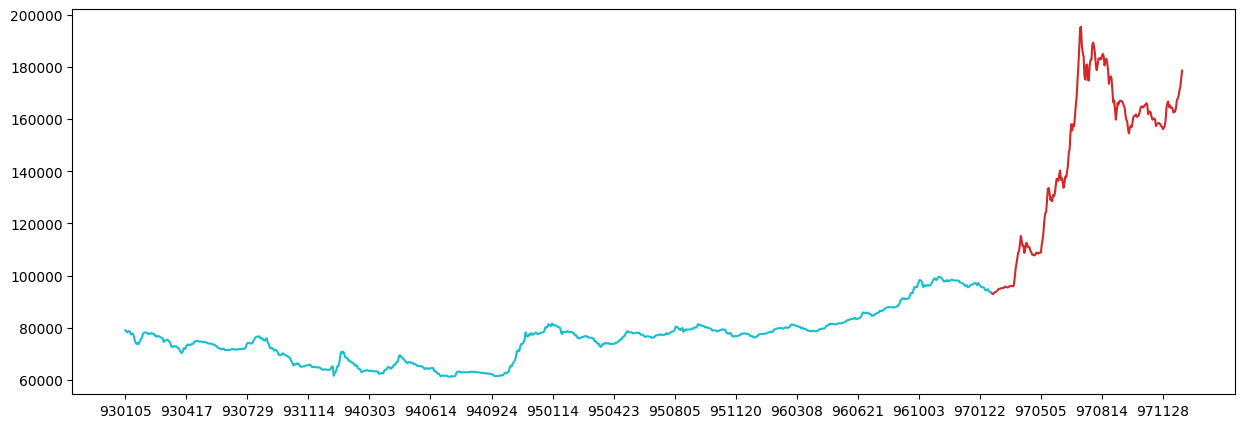

In [9]:
plt.plot(df2["dateissue"], df2["Value"], color=color_pal[9])
plt.plot(df1["dateissue"], df1["Value"], color=color_pal[3]) # after barjam (red)
plt.xticks(np.arange(0, len(df), step=70))
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [10]:
df.shape

(1213, 2)

In [11]:
df.index = df.pop("dateissue")
df

,Value
dateissue,
930105,79013.5
930106,78619.4
930109,78239.7
930110,78469.2
930111,78741.3
...,...
971222,169115.5
971225,171124.9
971226,172522.5


### preprocessing

In [12]:
# scaler = MinMaxScaler(feature_range=(0,1))
# dataset = scaler.fit_transform(dataset)
# dataset

# test_dataset = [i for i in dataset if i not in train_dataset]
# test_dataset

# df['Value'] = df['Value'] / 100000

df_mean = df['Value'].mean()
df['Value'] = df['Value'] / df_mean
clear_output()
df

,Value
dateissue,
930105,0.890553
930106,0.886111
930109,0.881832
930110,0.884418
930111,0.887485
...,...
971222,1.906084
971225,1.928732
971226,1.944484


In [13]:
dataset = df.values

##### split train and test datasets  

In [14]:
train_count = math.ceil(len(dataset) * 0.80) # find 80% of our dataset
print(train_count)
print(len(dataset)-train_count)
print(dataset.shape)

971
242
(1213, 1)


In [15]:
train_dataset = dataset[0:train_count]
train_dataset = np.array(train_dataset)
train_dataset

array([[0.89055322],
       [0.88611136],
       [0.8818318 ],
       [0.88441847],
       [0.88748529],
       [0.88530324],
       [0.87501291],
       [0.87257727],
       [0.87707323],
       [0.872637  ],
       [0.86224411],
       [0.84442369],
       [0.83374676],
       [0.83232888],
       [0.83586344],
       [0.82996425],
       [0.83584991],
       [0.84571533],
       [0.85360383],
       [0.85636859],
       [0.87241384],
       [0.87826907],
       [0.88060778],
       [0.88083545],
       [0.88098198],
       [0.87844264],
       [0.87427466],
       [0.87646798],
       [0.87594388],
       [0.87633949],
       [0.87835248],
       [0.87613436],
       [0.87458123],
       [0.87473677],
       [0.86675247],
       [0.86771838],
       [0.86254955],
       [0.86373863],
       [0.86523991],
       [0.86452195],
       [0.86103136],
       [0.8589778 ],
       [0.85735254],
       [0.8530617 ],
       [0.84017118],
       [0.84234082],
       [0.84647612],
       [0.849

##### we should create a sequence(to make an iteratin on the dataset) for every data in the dataframe to use it for lstm and rnn  models in the future.

Example:

X = [[[1], [2], [3], [4], [5]]] Y = [6]

X = [[[2], [3], [4], [5], [6]]] Y = [7]

X = [[[3], [4], [5], [6], [7]]] Y = [8]

In [16]:
x_train = []
y_train = []

for i in range(10,train_count):
    x_train.append(train_dataset[i-10:i, 0])
    y_train.append(train_dataset[i,0])
    if i<=10 : #we can get the first round of the train dataset which we created
        print(x_train)
        print(y_train)

[array([0.89055322, 0.88611136, 0.8818318 , 0.88441847, 0.88748529,
       0.88530324, 0.87501291, 0.87257727, 0.87707323, 0.872637  ])]
[0.8622441058512378]


In [17]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(961, 10)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(961, 10, 1)